## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

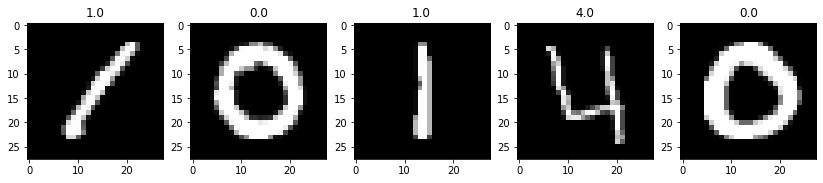

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [5]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2,
    random_state=42)

## PCA

In [6]:
y = y_train
X = x_train.reshape(-1, 28 * 28).astype(np.float32)

In [7]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [8]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [9]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

## Собственные числа

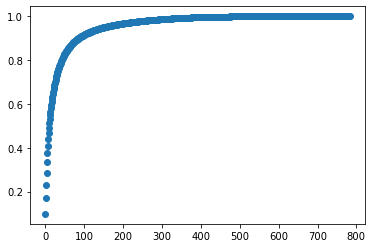

In [10]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [11]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.098
[001] 0.169
[002] 0.231
[003] 0.285
[004] 0.334


## Понижаем размерность

In [12]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.751


In [13]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

## Восстанавливаем изображение после понижения размерности

In [14]:
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

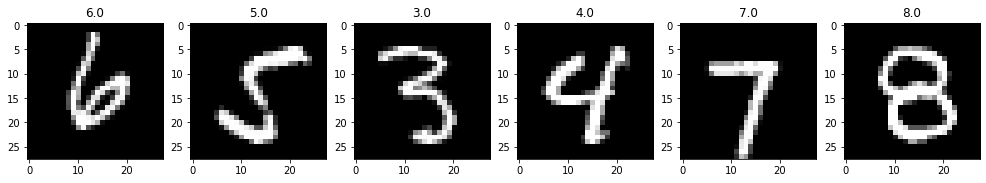

In [15]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)), cmap='gray');

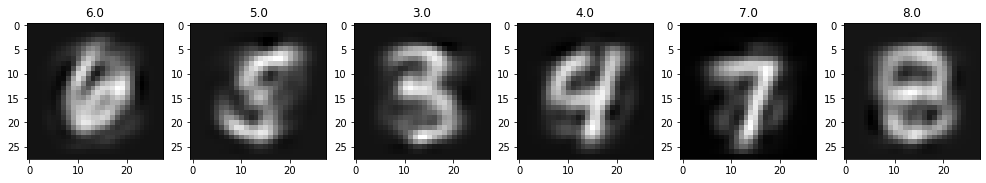

In [16]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray');

## Визуализация собственных векторов

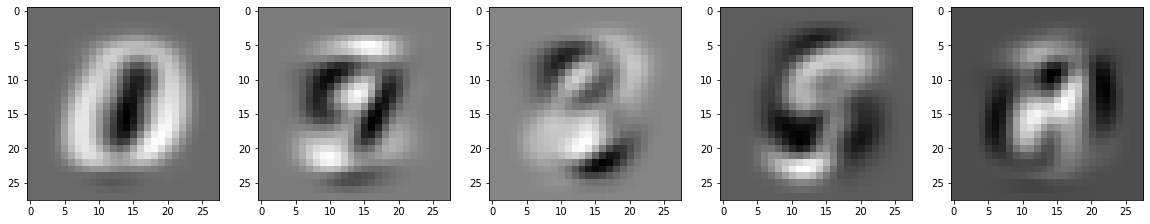

In [17]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(U.T[:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img.reshape((28,28)), cmap='gray');

## LogisticRegressionClassifier

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression(solver = 'lbfgs', n_jobs=-1)

In [20]:
lr.fit(Xrot_reduced,y)

LogisticRegression(n_jobs=-1)

In [21]:
def prepare_to_predict(ima):
    images = ima.reshape(-1, 28 * 28).astype(np.float32)
    images_mean = images.mean(axis=0)
    images -= images_mean
    print(images.shape)
    return images

In [22]:
predictions = lr.predict(np.dot(prepare_to_predict(x_val), U[:, :n_comp]))

(8400, 784)


In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predictions)

0.8935714285714286

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       816
         1.0       0.94      0.98      0.96       909
         2.0       0.90      0.86      0.88       846
         3.0       0.89      0.83      0.86       937
         4.0       0.87      0.92      0.89       839
         5.0       0.80      0.83      0.82       702
         6.0       0.90      0.93      0.92       785
         7.0       0.91      0.90      0.91       893
         8.0       0.87      0.86      0.86       835
         9.0       0.86      0.86      0.86       838

    accuracy                           0.89      8400
   macro avg       0.89      0.89      0.89      8400
weighted avg       0.89      0.89      0.89      8400



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, predictions))

[[783   0   1   2   2  15   8   0   4   1]
 [  0 888   3   0   1   4   1   3   9   0]
 [  5  16 729  16  24   8  10  12  24   2]
 [  3   6  24 775   0  58   7  13  31  20]
 [  1   3   6   1 768   3  18   2   5  32]
 [  5   6   6  29  15 586  25   4  18   8]
 [ 11   2   7   1  17   8 732   1   5   1]
 [  0   8  16   4  15   6   0 805   4  35]
 [  4  14   9  24   7  34   8   5 716  14]
 [  3   5   5  15  30  10   0  41   5 724]]


## Оцениваем качество решение на валидационной выборке

In [26]:
predictions_final = lr.predict(np.dot(prepare_to_predict(test_img), U[:, :n_comp])).astype(int)

(28000, 784)


In [27]:
predictions_final.astype(int)

array([2, 0, 9, ..., 3, 9, 2])

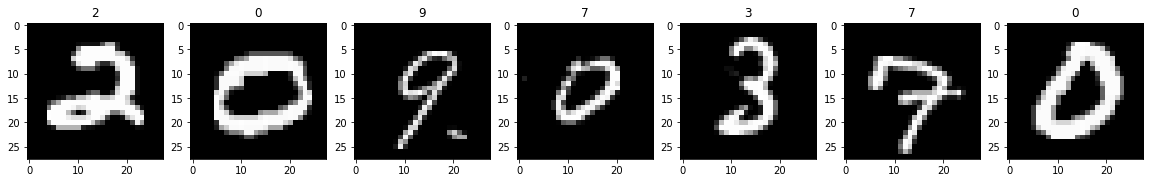

In [28]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predictions_final[i - 1]);

## Готовим файл для отправки

In [29]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predictions_final.astype(int), 1):
        dst.write('%s,%s\n' % (i, p))